# Proyek Klasifikasi Gambar: [Sports Image Classification](https://www.kaggle.com/datasets/sidharkal/sports-image-classification/data)
- **Nama:** Althaf Yudhistira
- **Email:** althafbanfsaj@gmail.com
- **ID Dicoding:** althafby

## Import Semua Packages/Library yang Digunakan

In [ ]:
import os
import gc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
tf.keras.backend.clear_session()
gc.collect()


0

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Preparation

### Data Loading

In [ ]:
from google.colab import drive
import shutil
# Copy zip into colab local
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/olahraga.zip'
colab_zip_path = '/content/olahraga.zip'
shutil.copy(drive_path, colab_zip_path)



Mounted at /content/drive


'/content/olahraga.zip'

In [ ]:
import zipfile
data_path='/content/dataset'
with zipfile.ZipFile(colab_zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)
os.listdir(data_path+'/dataset')

['train.csv', 'test', 'sample_submission.csv', 'test.csv', 'train']

In [ ]:
data_path='/content/dataset/dataset'
tr_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
test_df = pd.read_csv('/content/output.csv')
testing_df = pd.read_csv(os.path.join(data_path, 'test.csv'))

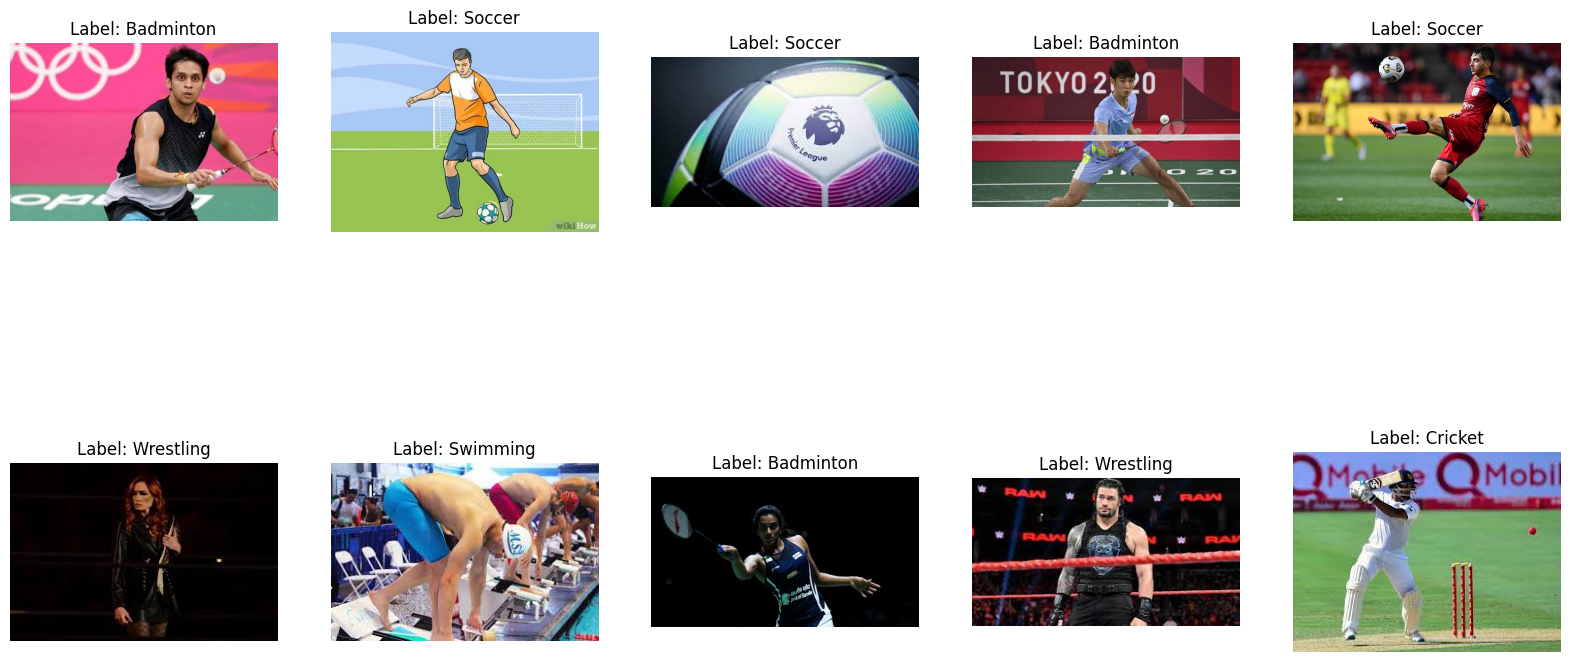

In [ ]:
tr_path ='/content/dataset/dataset/train'
sample = tr_df.sample(n=10)

plt.figure(figsize=(20, 10))

for i, (index, row) in enumerate(sample.iterrows(), 1):
    image_id = row['image_ID']
    label = row['label']
    image_path = os.path.join(tr_path, image_id)
    img = mpimg.imread(image_path)
    plt.subplot(2, 5, i)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')

In [ ]:
count = tr_df['label'].value_counts()
print("Label distribution:\n", count)

Label distribution:
 label
Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: count, dtype: int64


#### Split Dataset

In [ ]:
new_train, val = train_test_split(
    tr_df,
    test_size=0.1,
    random_state=42,
    stratify=tr_df["label"]
)

new_train.to_csv("trains.csv", index=False)
val.to_csv("vals.csv", index=False)

print(f"New training samples: {len(new_train)}")
print(f"Validation samples: {len(val)}")
val_df = pd.read_csv('/content/vals.csv')
sp_train = pd.read_csv('/content/trains.csv')


New training samples: 7404
Validation samples: 823


In [ ]:
count = val_df['label'].value_counts()
print("Label distribution:\n", count)

Label distribution:
 label
Cricket      156
Wrestling    147
Tennis       145
Badminton    139
Soccer       119
Swimming      59
Karate        58
Name: count, dtype: int64


### Data Preprocessing

In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=sp_train,
    directory=tr_path,
    x_col='image_ID',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory= tr_path,
    x_col='image_ID',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128
)
test_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/dataset/dataset/test',
    x_col='image_ID',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128,
    shuffle=False

)



Found 7404 validated image filenames belonging to 7 classes.
Found 823 validated image filenames belonging to 7 classes.
Found 2056 validated image filenames belonging to 7 classes.


## Modelling

In [ ]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95):
            print("\nReached 95% accuracy")
            self.model.stop_training = True
callbacks = Callback()

#checkpoint = ModelCheckpoint(
#    'model.keras',
#    monitor='val_accuracy',
#    save_best_only=True,
#    mode='max',
#    verbose=1
#)


In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)
base_model = tf.keras.applications.EfficientNetB4(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(7, activation='softmax', dtype='float32')
])

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=870
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[callbacks],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step - accuracy: 0.7622 - loss: 0.7431 - val_accuracy: 0.9174 - val_loss: 0.3568
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9270 - loss: 0.2138 - val_accuracy: 0.9332 - val_loss: 0.2605
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9434 - loss: 0.1660 - val_accuracy: 0.9429 - val_loss: 0.2013
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9527 - loss: 0.1298
Reached 95% accuracy
58/58 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9527 - loss: 0.1299 - val_accuracy: 0.9526 - val_loss: 0.1704


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 1792)                │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1792)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         918,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,442,745 (77.98 MB)

 Trainable params: 922,631 (3.52 MB)

 Non-trainable params: 17,674,847 (67.42 MB)

 Optimizer params: 1,845,267 (7.04 MB)

## Evaluasi dan Visualisasi

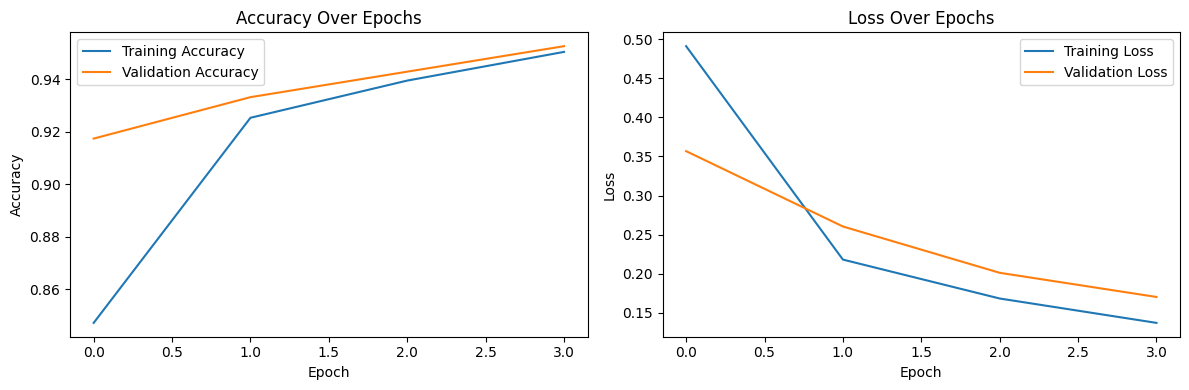

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.tight_layout()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 567ms/step - accuracy: 0.9681 - loss: 0.1071

Test Loss: 0.1130
Test Accuracy: 0.9650
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 616ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.9576    0.9461    0.9518       334
           1     0.9840    0.9788    0.9814       378
           2     0.9562    0.8973    0.9258       146
           3     0.9618    0.9773    0.9695       309
           4     0.9792    0.9792    0.9792       144
           5     0.9514    0.9538    0.9526       390
           6     0.9670    0.9915    0.9791       355

    accuracy                         0.9650      2056
   macro avg     0.9653    0.9606    0.9628      2056
weighted avg     0.9650    0.9650    0.9649      2056



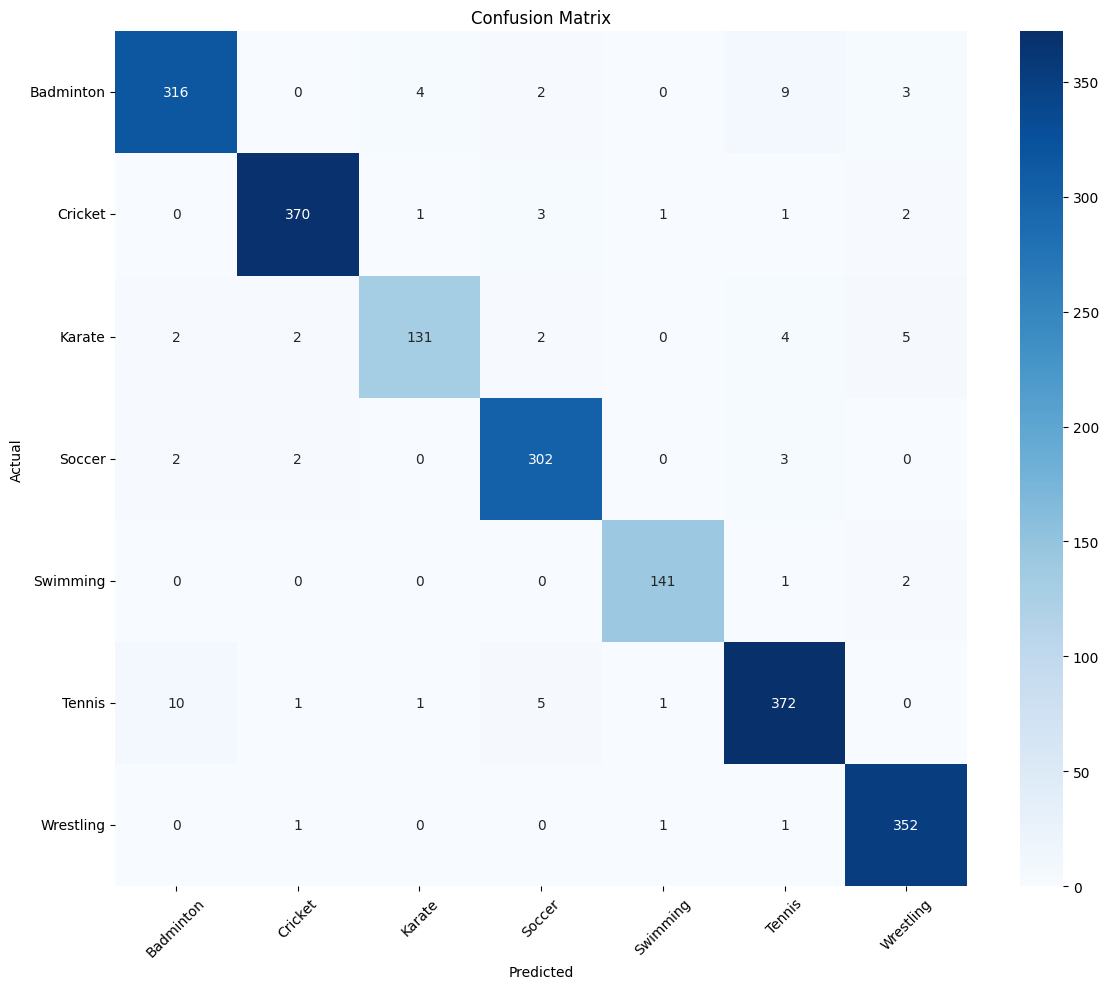

In [ ]:

test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

y_pred_probs = model.predict(test_generator)
y_pred = y_pred_probs.argmax(axis=1)
y_true = test_generator.classes

# 4. Calculate metrics
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


# 5. Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Konversi Model

In [ ]:
  model.export('save_models')
  model.save("model_relu.keras")


Saved artifact at 'save_models'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name='keras_tensor_1445')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  137972783520016: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  137972783518672: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  137973569302224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137973569299920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137973569298192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137973569300112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137973569301264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137973569296656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137973569298768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137973569297424: TensorSpec(shape=(), dtype=tf.resource, name=None

In [ ]:
print(os.listdir('save_models'))

['assets', 'variables', 'saved_model.pb', 'fingerprint.pb']


In [ ]:
!pip freeze > requirements.txt

In [ ]:
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r sample_folder.zip /content/save_models/
files.download('sample_folder.zip')

updating: content/save_models/ (stored 0%)
updating: content/save_models/assets/ (stored 0%)
updating: content/save_models/variables/ (stored 0%)
updating: content/save_models/variables/variables.data-00000-of-00001


zip error: Interrupted (aborting)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

Saving 475907899_18016747019669275_355190100570453531_n.jpg to 475907899_18016747019669275_355190100570453531_n (1).jpg


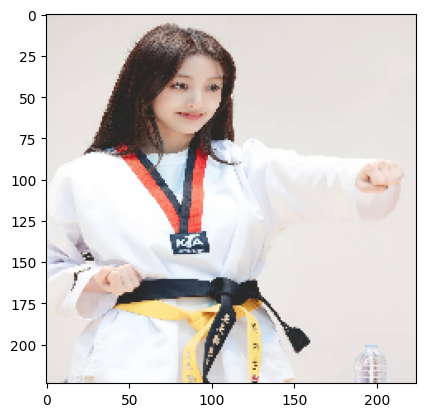

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Karate
Confidence: 99.81%
-------------------


In [ ]:
new_model = tf.keras.models.load_model('model_relu.keras')
class_labels = ['Badminton','Cricket','Karate', 'Soccer','Swimming', 'Tennis','Wrestling']  # Example: ['cat', 'dog', 'horse']
uploaded = files.upload()
for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  plt.show()

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  predictions = new_model.predict(images, batch_size=10)
  predicted_class_index = np.argmax(predictions[0])
  predicted_class = class_labels[predicted_class_index]
  confidence = predictions[0][predicted_class_index]

  print(f"Predicted class: {predicted_class}")
  print(f"Confidence: {confidence:.2%}")
  print("-------------------")